In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [4]:
historical = pd.read_json('../data/processed/historical.json')
fear = pd.read_json('../data/processed/fear.json')

In [5]:
historical['time'] = pd.to_datetime(historical['time'], unit='s')
fear.rename(columns={'timestamp': 'time'}, inplace=True)

In [6]:
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              2001 non-null   datetime64[ns]
 1   high              2001 non-null   float64       
 2   low               2001 non-null   float64       
 3   open              2001 non-null   float64       
 4   volumefrom        2001 non-null   float64       
 5   volumeto          2001 non-null   float64       
 6   close             2001 non-null   float64       
 7   conversionType    2001 non-null   object        
 8   conversionSymbol  2001 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 140.8+ KB


In [7]:
fear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   value                 2000 non-null   int64         
 1   value_classification  2000 non-null   object        
 2   time                  2000 non-null   datetime64[ns]
 3   time_until_update     1 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 62.6+ KB


In [8]:
data = pd.merge(fear, historical, on='time', how='left')
data.drop(columns=['time_until_update', 'conversionType', 'conversionSymbol', 'value_classification'], inplace=True)
data.rename(columns={"value": "fear_greed"}, inplace=True)
data.dropna(inplace=True)

In [9]:
data.head()

,fear_greed,time,high,low,open,volumefrom,volumeto,close
0,47,2025-02-18,96736.69,95104.15,95790.31,6903.53,6.620163e+08,96394.39
1,51,2025-02-17,97046.20,95226.61,96132.69,14565.31,1.398129e+09,95790.31
2,54,2025-02-16,97728.27,96069.15,97596.21,6632.76,6.431463e+08,96132.69
3,50,2025-02-15,97979.54,97245.24,97508.71,5831.48,5.691206e+08,97596.21
4,48,2025-02-14,98869.28,96282.72,96632.78,20187.22,1.966705e+09,97508.71


In [10]:

# data_last_day = data.groupby(data['time'].dt.to_period('M')).last()
# data_last_day.head()

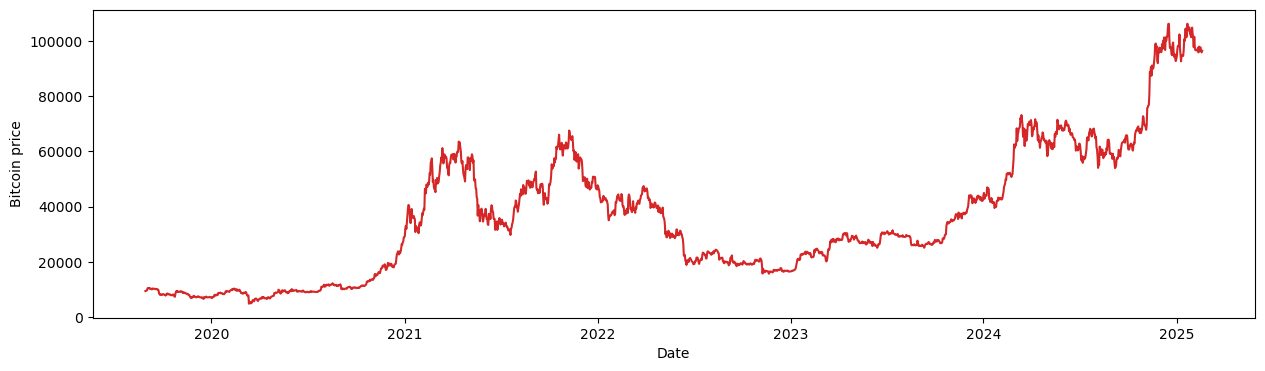

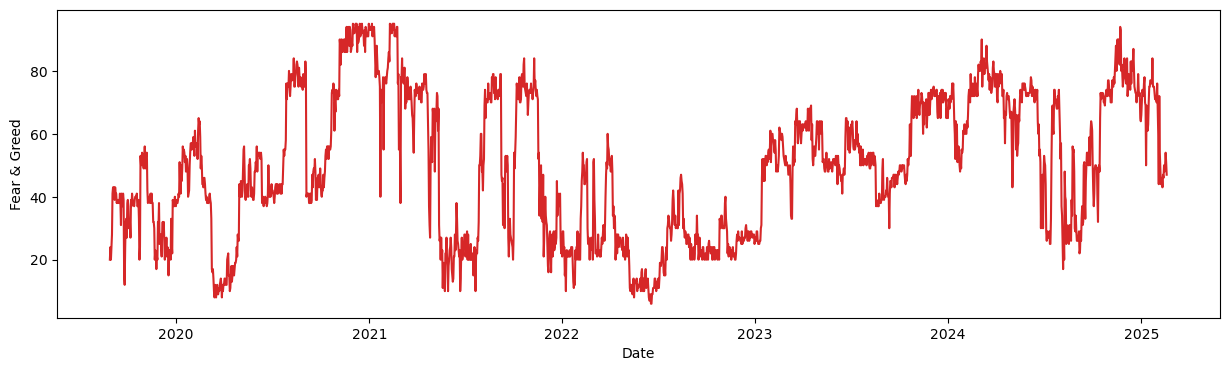

In [11]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, data['time'], data['close'], xlabel='Date', ylabel='Bitcoin price')
plot_df(data, data['time'], data['fear_greed'], xlabel='Date', ylabel='Fear & Greed')

# Data Preprocessing

In [12]:
shift_window = 1

def create_features(df, window=shift_window):
    df = df.copy()
    for i in range(1, window+1):
        df[f'high_lag_{i}'] = df['high'].shift(-i)
        df[f'low_lag_{i}'] = df['low'].shift(-i)
        df[f'volumefrom_lag_{i}'] = df['volumefrom'].shift(-i)
        df[f'volumeto_lag_{i}'] = df['volumeto'].shift(-i)
    return df

new_features = create_features(data)
new_features.dropna(inplace=True)
time = new_features['time']
new_features.drop(columns=['high', 'low', 'volumefrom', 'volumeto', 'time'], inplace=True)
new_features.head()

,fear_greed,open,close,high_lag_1,low_lag_1,volumefrom_lag_1,volumeto_lag_1
0,47,95790.31,96394.39,97046.20,95226.61,14565.31,1.398129e+09
1,51,96132.69,95790.31,97728.27,96069.15,6632.76,6.431463e+08
2,54,97596.21,96132.69,97979.54,97245.24,5831.48,5.691206e+08
3,50,97508.71,97596.21,98869.28,96282.72,20187.22,1.966705e+09
4,48,96632.78,97508.71,98104.11,95225.08,23246.76,2.236345e+09


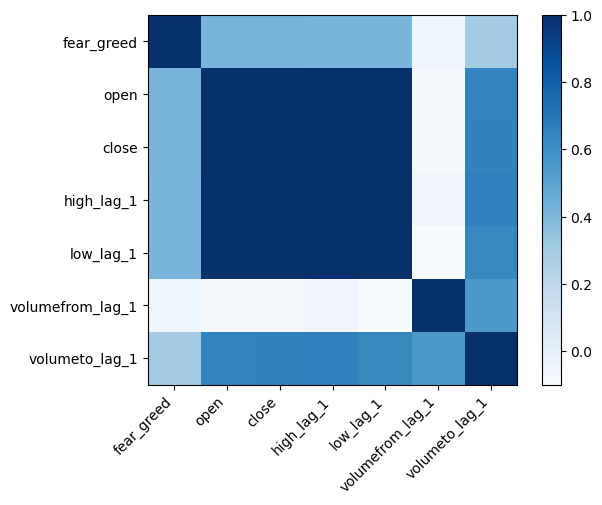

In [13]:
matrix = new_features.corr()

plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

In [14]:
# X = new_features.drop(columns='close')
# y = new_features['close']

X = data.drop(columns=['close', 'high', 'low', 'volumefrom', 'volumeto', 'time'])
y = data['close']

In [15]:
scaler = MinMaxScaler()
d = scaler.fit_transform(X)

norm_data = pd.DataFrame(d, columns=X.columns)
norm_data.head()

,fear_greed,open
0,0.460674,0.897615
1,0.505618,0.900997
2,0.539326,0.915453
3,0.494382,0.914589
4,0.471910,0.905937


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.03, random_state=42)

In [17]:
# shift = data.iloc[:shift_window]
record = [51, 96959.29]

# for i in range(len(shift)):
#     info = shift.iloc[i][['high', 'low', 'volumefrom', 'volumeto']].to_list()
#     # print(info)
#     record = record + info

# print(record)

record = np.array(record).reshape(1, -1)

norm_record = scaler.transform(record)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Linear Regression

In [18]:
lr = LinearRegression()

lr.fit(x_train, y_train)


pred = lr.predict(x_test)

# lr.score(x_test, y_test)

print(mean_absolute_percentage_error(pred, y_test))

0.022685068103271873


In [19]:
lr.score(x_test, y_test)

0.9083756085829483

In [20]:
lr.predict(record)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([96947.7201279])

# XGBoost

In [21]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
pred = model.predict(x_test)

In [23]:
print(mean_absolute_percentage_error(pred, y_test))

0.026593066586601252


In [24]:
model.score(x_test, y_test)

0.8860113143431793

In [25]:
model.predict(record)

array([96104.99], dtype=float32)